<a href="https://colab.research.google.com/github/upriyam-cmu/10-708/blob/main/notebooks/movie_lens_dataset_preproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
! pip install torch_geometric
! pip install sentence_transformers

In [74]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch_geometric.datasets import MovieLens1M
from sklearn.preprocessing import QuantileTransformer

In [76]:
ml_1m = MovieLens1M("/content/movie_lens")
ml_1m.process()

In [134]:
processed_data = torch.load("/content/movie_lens/processed/data.pt")

In [135]:
processed_data

({'_global_store': {},
  'movie': {'x': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
           [0., 1., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 1., 0., 0.]])},
  'user': {'x': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 1.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 1.,  ..., 0., 0., 0.]])},
  ('user',
   'rates',
   'movie'): {'edge_index': tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
           [1176,  655,  902,  ...,  558, 1080, 1081]]), 'rating': tensor([5, 3, 3,  ..., 5, 4, 4]), 'time': tensor([978300760, 978302109, 978301968,  ..., 956704746, 956715648,
           956715569])},
  ('movie',
   'rated_by',
   'user'): {'edge_index': tensor([[1176,  655,  902,  ...,  55

In [136]:
processed_data[0]

{'_global_store': {},
 'movie': {'x': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.]])},
 'user': {'x': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 0., 0.]])},
 ('user',
  'rates',
  'movie'): {'edge_index': tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
          [1176,  655,  902,  ...,  558, 1080, 1081]]), 'rating': tensor([5, 3, 3,  ..., 5, 4, 4]), 'time': tensor([978300760, 978302109, 978301968,  ..., 956704746, 956715648,
          956715569])},
 ('movie',
  'rated_by',
  'user'): {'edge_index': tensor([[1176,  655,  902,  ...,  558, 1080, 1081],
       

In [137]:
processed_data[0]["user"]["x"]

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [ ]:
! ls movie_lens/processed

data.pt  pre_filter.pt	pre_transform.pt


In [7]:
ml_1m[0]

HeteroData(
  movie={ x=[3883, 18] },
  user={ x=[6040, 30] },
  (user, rates, movie)={
    edge_index=[2, 1000209],
    rating=[1000209],
    time=[1000209],
  },
  (movie, rated_by, user)={
    edge_index=[2, 1000209],
    rating=[1000209],
    time=[1000209],
  }
)

In [138]:
edges = processed_data[0][('user','rates','movie')]

In [139]:
edge_ratings = torch.concatenate([edges["edge_index"], edges["rating"].reshape((1,-1))])

In [140]:
edge_ratings.shape

torch.Size([3, 1000209])

(array([ 56174., 107557., 261197., 348971., 226310.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

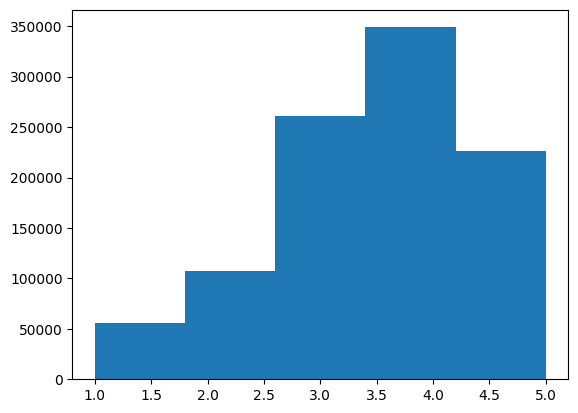

In [22]:
import matplotlib.pyplot as plt

ratings = edge_ratings[2,:]
plt.hist(ratings, bins=5)

In [141]:
def naive_transform(ratings):
    empirical_quantiles = ecdf(ratings).cdf.probabilities
    return 2*empirical_quantiles[ratings] - 1

qt_transformer = QuantileTransformer(n_quantiles=5, output_distribution="normal")
edge_ratings[-1,:] = torch.Tensor(qt_transformer.fit_transform(ratings.reshape(-1, 1))).T

(array([ 56174.,      0.,      0.,      0.,      0., 717725.,      0.,
             0.,      0., 226310.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <BarContainer object of 10 artists>)

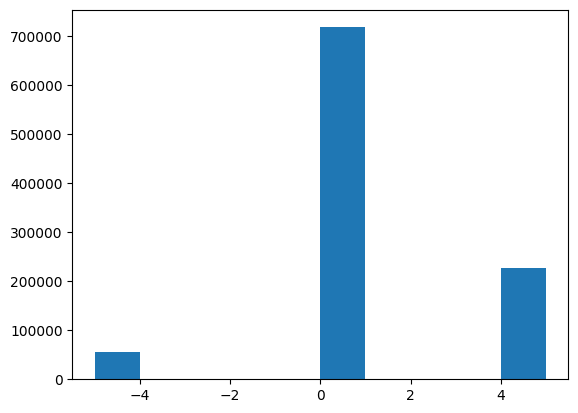

In [142]:
plt.hist(edge_ratings[-1,:])

(array([ 56174., 107557.,      0., 261197.,      0.,      0.,      0.,
        348971.,      0., 226310.]),
 array([-0.88767548, -0.69890793, -0.51014038, -0.32137283, -0.13260529,
         0.05616226,  0.24492981,  0.43369736,  0.6224649 ,  0.81123245,
         1.        ]),
 <BarContainer object of 10 artists>)

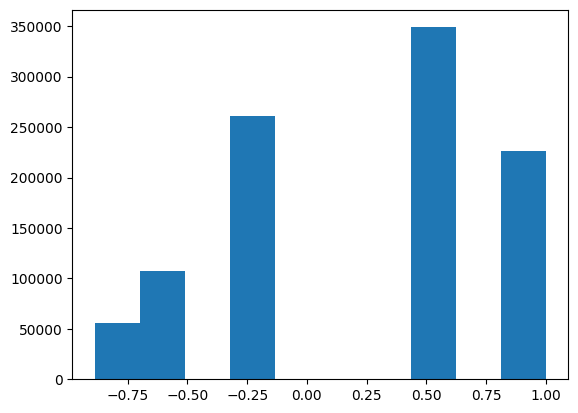

In [40]:
plt.hist(2*empirical_quantiles[ratings-1] - 1)

In [27]:
ratings.numpy().mean()

3.581564453029317

In [66]:
_, edge_size = edge_ratings.shape
indices = torch.randint(0, edge_size, (10,))
sampled_edges = torch.ones((1,1))
while len(sampled_edges[0, :].unique()) < 10 or len(sampled_edges[1, :].unique()) < 10:
    indices = torch.randint(0, edge_size, (10,))
    sampled_edges = edge_ratings[:, indices]

In [67]:
xs = edge_ratings[0, indices]
ys = edge_ratings[1, indices]

In [68]:
indices_xs = torch.where(torch.isin(edge_ratings[0,:], xs))[0]
indices_ys = torch.where(torch.isin(edge_ratings[1,:], ys))[0]
subsample_edges = edge_ratings[:, np.intersect1d(indices_xs, indices_ys)].T #TODO: Check if this results in less than 10 users/movie and fill spots

In [69]:
xs.unique().sort().values, ys.unique().sort().values

(tensor([ 654, 1868, 3043, 3568, 3623, 3937, 4013, 4724, 5566, 5787]),
 tensor([ 228,  315,  366, 1132, 1186, 2040, 2298, 2614, 3036, 3179]))

In [70]:
movie_feats, user_feats = processed_data[0]["movie"]["x"], processed_data[0]["user"]["x"]
subsample_movie_feats = movie_feats[subsample_edges[:,1], :]
subsample_user_feats = user_feats[subsample_edges[:,0], :]
subsample_user_movie_feats = torch.cat([subsample_movie_feats, subsample_user_feats], dim=1)

In [83]:
torch.cat([subsample_movie_feats, subsample_user_feats], dim=1).shape

torch.Size([36, 48])

In [86]:
movie_feats[ys.unique().sort().values, :].shape, user_feats[xs.unique().sort().values, :].shape

(torch.Size([10, 18]), torch.Size([10, 30]))

In [84]:
broadcasted_movie_feats, broadcasted_user_feats = (
    torch.broadcast_to(movie_feats[ys.unique().sort().values, :].reshape((18,1,10)), (18,10,10)),
    torch.broadcast_to(user_feats[xs.unique().sort().values, :].reshape((30,10,1)), (30,10,10))
)
feature_tensor = torch.cat([broadcasted_movie_feats, broadcasted_user_feats], dim=0)

In [73]:
rating_matrix = torch.Tensor(pd.DataFrame(subsample_edges).pivot(columns=[1], index=[0]).fillna(3).to_numpy())
batch = torch.cat([rating_matrix.reshape((1,10,10)), feature_tensor], dim=0)
batch.shape

torch.Size([49, 10, 10])

In [143]:
! pip install torch_geometric
! pip install sentence_transformers

import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch_geometric.datasets import MovieLens1M
from sklearn.preprocessing import QuantileTransformer

class RatingQuantileTransform(object):
    def __init__(self):
        self.qt_transformer = QuantileTransformer(n_quantiles=5, output_distribution="normal")

    def __call__(self, data):
        ratings = data[2,:]
        data[2,:] = torch.Tensor(self.qt_transformer.fit_transform(ratings.reshape(-1, 1))).T
        return data

class ProcessedMovieLens(Dataset):
    PROCESSED_ML_SUBPATH = "/processed/data.pt"

    def __init__(self, root, dataset_transform=None, transform=None, download=True):
        if download:
            ml_1m = MovieLens1M(root)
            ml_1m.process()

        self.transform = transform
        self.dataset_transform = dataset_transform
        print(root + self.PROCESSED_ML_SUBPATH)
        self.processed_data = torch.load(root + self.PROCESSED_ML_SUBPATH)
        self.processed_ratings = self._preprocess_ratings(self.processed_data)

    def _preprocess_ratings(self, data):
        edges = data[0][('user','rates','movie')]
        edge_ratings = torch.concatenate([edges["edge_index"], edges["rating"].reshape((1,-1))])
        return self.dataset_transform(edge_ratings)

    def get_item(self, n_unique=10):
        edge_ratings = self.processed_ratings
        movie_feats, user_feats = self.processed_data[0]["movie"]["x"], self.processed_data[0]["user"]["x"]

        _, edge_size = edge_ratings.shape
        indices = torch.randint(0, edge_size, (n_unique,))
        sampled_edges = torch.ones((1,1))
        while len(sampled_edges[0, :].unique()) < n_unique or len(sampled_edges[1, :].unique()) < n_unique:
            indices = torch.randint(0, edge_size, (n_unique,))
            sampled_edges = edge_ratings[:, indices]

        xs = edge_ratings[0, indices]
        ys = edge_ratings[1, indices]

        indices_xs = torch.where(torch.isin(edge_ratings[0,:], xs))[0]
        indices_ys = torch.where(torch.isin(edge_ratings[1,:], ys))[0]
        subsample_edges = edge_ratings[:, np.intersect1d(indices_xs, indices_ys)].T

        subsample_movie_feats = movie_feats[subsample_edges[:,1], :]
        subsample_user_feats = user_feats[subsample_edges[:,0], :]
        subsample_user_movie_feats = torch.cat([subsample_movie_feats, subsample_user_feats], dim=1)

        broadcasted_movie_feats, broadcasted_user_feats = (
            torch.broadcast_to(movie_feats[ys.unique().sort().values, :].reshape((18,1,n_unique)), (18,n_unique,n_unique)),
            torch.broadcast_to(user_feats[xs.unique().sort().values, :].reshape((30,n_unique,1)), (30,n_unique,n_unique))
        )

        rating_matrix = torch.Tensor(pd.DataFrame(subsample_edges).pivot(columns=[1], index=[0]).fillna(3).to_numpy())
        item = torch.cat([rating_matrix.reshape((1,n_unique,n_unique)), broadcasted_movie_feats, broadcasted_user_feats], dim=0)

        return item

In [126]:
processed_movie_lens = ProcessedMovieLens("/content/movie_lens", RatingQuantileTransform(), download=False)

/content/movie_lens/processed/data.pt
tensor([[   0,    0,    0,  ..., 6039, 6039, 6039],
        [1176,  655,  902,  ...,  558, 1080, 1081],
        [   5,    0,    0,  ...,    5,    0,    0]])
